In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix,precision_score, recall_score, f1_score

# Load the dataset
url = 'https://raw.githubusercontent.com/aarsh-adhvaryu/Datasets/refs/heads/main/telecom_churn.csv'
df = pd.read_csv(url)

print("Dataset loaded successfully.")

Dataset loaded successfully.


In [11]:
# Clean negative values
cols_to_clean = ['num_dependents', 'calls_made', 'sms_sent', 'data_used']
for col in cols_to_clean:
    df[col] = df[col].abs()

# Create the tenure feature
df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
latest_date = df['date_of_registration'].max()
df['customer_tenure_days'] = (latest_date - df['date_of_registration']).dt.days

print("Data cleaned and 'customer_tenure_days' feature created.")

Data cleaned and 'customer_tenure_days' feature created.


In [12]:
# Group rare categories for 'state'
state_counts = df['state'].value_counts()
# Keep states that appear more than 2000 times, group the rest
states_to_keep = state_counts[state_counts > 2000].index
df['state__grouped'] = df['state'].where(df['state'].isin(states_to_keep), 'Other')

# Group rare categories for 'city'
city_counts = df['city'].value_counts()
# Keep cities that appear more than 10000 times, group the rest
cities_to_keep = city_counts[city_counts > 10000].index
df['city_grouped'] = df['city'].where(df['city'].isin(cities_to_keep), 'Other')

print("Grouped rare categories in 'state' and 'city'.")

Grouped rare categories in 'state' and 'city'.


In [13]:
# Drop original and unused columns
df_model = df.drop(columns=[
    'customer_id', 'pincode', 'date_of_registration', 'state', 'city'
])

# Separate features (X) and target (y)
X = df_model.drop('churn', axis=1)
y = df_model['churn']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data has been prepared and split for the pipeline.")

Data has been prepared and split for the pipeline.


In [14]:
# --- 1. Prepare Data for Pipelines 🔪 ---
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
# Drop original and unused columns from the dataframe
df_model = df.drop(columns=[
    'customer_id', 'pincode', 'date_of_registration', 'state', 'city'
])

# Separate features (X) and target (y)
X = df_model.drop('churn', axis=1)
y = df_model['churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data has been prepared and split.\n")


# --- 2. Create the Preprocessing Pipeline 🏗️ ---

# Identify final numerical and categorical column names
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Create preprocessing steps for numerical and categorical data
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a single preprocessor object
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# --- 3. Define, Train, and Evaluate Models 🚀 ---
import xgboost as xgb

# Calculate scale_pos_weight for XGBoost to handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# Define the models to compare
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=150, random_state=42, n_jobs=-1),
    "XGBoost (GPU)": xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        device='cuda',
        random_state=42
    )
}

# List to store results
results_train = []

# Loop through each model to build a pipeline, train, and evaluate
for name, model in models.items():
    print(f"Processing {name}...")

    # Create the full pipeline with the preprocessor and the current model
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the pipeline
    model_pipeline.fit(X_train, y_train)

    # Make predictions on the TRAINING data
    y_pred_train = model_pipeline.predict(X_train)

    # Calculate metrics
    results_train.append({
        "Model": name,
        "Precision": precision_score(y_train, y_pred_train),
        "Recall": recall_score(y_train, y_pred_train),
        "F1-Score": f1_score(y_train, y_pred_train)
    })

# --- 4. Display Results 📊 ---

# Create a DataFrame for easy comparison
results_train_df = pd.DataFrame(results_train)
print("\n--- Model Performance on Training Data ---")
print(results_train_df.to_string(index=False))

Data has been prepared and split.

Processing Logistic Regression...
Processing Random Forest...
Processing XGBoost (GPU)...

--- Model Performance on Training Data ---
              Model  Precision   Recall  F1-Score
Logistic Regression   0.205722 0.509549  0.293107
      Random Forest   1.000000 1.000000  1.000000
      XGBoost (GPU)   0.318385 0.690825  0.435882


In [17]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 1. Define the final pipeline with an XGBoost classifier placeholder
# The 'classifier' step will be what RandomizedSearchCV tunes
tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        device='cuda',
        scale_pos_weight=scale_pos_weight,
        random_state=42
    ))
])

# 2. Define the hyperparameter search space
# These are the parameter ranges that will be randomly sampled
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
    'classifier__gamma': [0, 0.1, 0.5, 1]
}

# 3. Set up and run the Randomized Search 🔍
# n_iter=50 means it will try 50 different combinations
random_search = RandomizedSearchCV(
    estimator=tuning_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,  # 3-fold cross-validation
    scoring='average_precision',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting hyperparameter tuning for the XGBoost pipeline...")
random_search.fit(X_train, y_train)

# 4. Print the best results
print("\n--- Tuning Complete ---")
print(f"Best Average Precision Score on CV: {random_search.best_score_:.4f}")
print("Best Parameters Found:")
print(random_search.best_params_)

Starting hyperparameter tuning for the XGBoost pipeline...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- Tuning Complete ---
Best Average Precision Score on CV: 0.2042
Best Parameters Found:
{'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.9}


--- Final Tuned XGBoost Model Performance on Test Set ---

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.53      0.64     38946
           1       0.20      0.46      0.28      9765

    accuracy                           0.52     48711
   macro avg       0.50      0.50      0.46     48711
weighted avg       0.68      0.52      0.57     48711


Confusion Matrix:


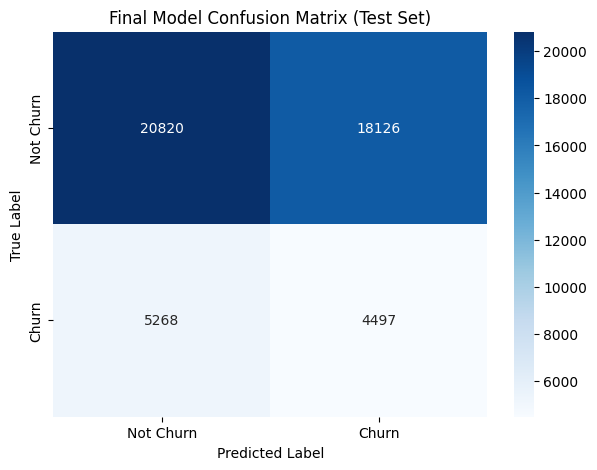

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get the best-performing pipeline from the random search
final_model = random_search.best_estimator_

# Make predictions on the held-out test data
y_pred_test = final_model.predict(X_test)

# --- Generate Final Reports ---
print("--- Final Tuned XGBoost Model Performance on Test Set ---")

# Report Precision, Recall, F1-Score, etc.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test)) # [cite: 79, 80]

# Display the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_test) # [cite: 80]
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'],
            yticklabels=['Not Churn', 'Churn'])
plt.title('Final Model Confusion Matrix (Test Set)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

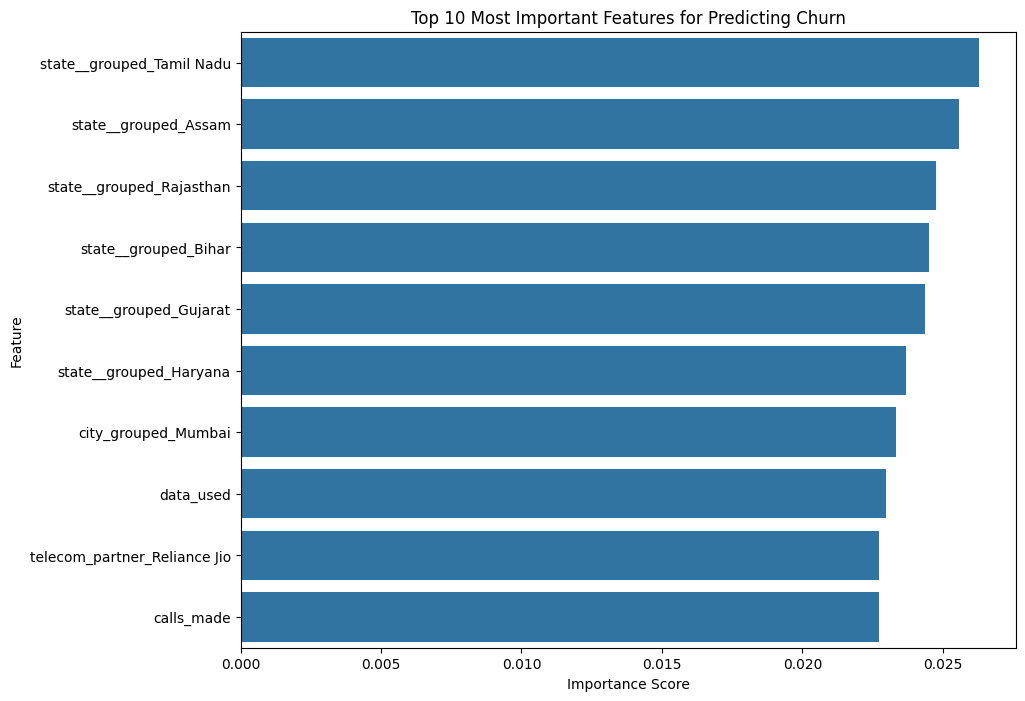

In [19]:
# Extract the trained preprocessor and classifier from the final pipeline
preprocessor = final_model.named_steps['preprocessor']
classifier = final_model.named_steps['classifier']

# Get the feature names from the preprocessor step
# This correctly handles the new columns created by the OneHotEncoder
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a pandas Series for easy plotting
importances = pd.Series(classifier.feature_importances_, index=all_feature_names)
top_10_features = importances.sort_values(ascending=False).head(10)

# Plot the top 10 most important features
plt.figure(figsize=(10, 8))
sns.barplot(x=top_10_features.values, y=top_10_features.index)
plt.title('Top 10 Most Important Features for Predicting Churn')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()